# Black Lives Matter Sentiment Classifier
## Nicholas Fasano

### Description: Given a dataset of 10,000+ tweets, I built a sentiment classifier to determine whether a given tweet was positive or negative toward the Black Lives Matter (BLM) movement.

### Sections: 
#### Section I: Load in Python packages
#### Section II: function definitions for preprocessing text (build bag of words)
#### Section III: Exploratory data analysis on training dataset
#### Section IV: Hypothesis testing of word count to trim vocabulary
#### Section V: Form training and testing data
#### Section VI: Train classifiers (SVM (linear and rbf kernels), random forest, logistic regression,  Naive Bayes, LDA, KNN)
#### Section VII: Evaluate model performance 

### Last edited: 03/16/2023

# Section I: Load in Python packages

In [1]:
# import the usual suspects
import time
import pandas as pd
import numpy as np
import regex as re
#import string

# import NLP packages
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english')) - {'all'}


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# plotting packages 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from PIL import Image


# import machine learning classifiers, model selection, and metric functions from sklearn
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, plot_roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV

# import statistical packages from scipy
from scipy.stats import bernoulli, norm, binom, binom_test, ttest_ind


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Section II:  Function definitions for preprocessing text (build bag of words)

In [2]:
# Gets the part of speech tag of word for lemmatization
# This function is based on code from:
#   https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Preprocesses the tweets text
# This function is based on code from:
#   https://www.pluralsight.com/guides/building-a-twitter-sentiment-analysis-in-python
def preprocess_text(tweet):
    # Changes emojis to words
    tweet = emoji.demojize(tweet,  delimiters=(' ', ' '))
    # Removes 'RT' from tweet
    tweet = re.sub(r'RT[\s]+', '', tweet)
    # Removes capitalization
    tweet = tweet.lower()
    # Removes urls & user mentions from tweet
    tweet = re.sub(r"http\S+|www\S+|https\S+|\@\w+", ' ', tweet, flags=re.MULTILINE)
    # Removes punctuation
    tweet = re.sub(r'\p{P}+', '', tweet)
    # Removes stopwords
    tokens = [w for w in word_tokenize(tweet) if not w in stop_words]
    # Perfoms lemmatization on tokens
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    return " ".join(lemma_words)

# Preprocesses the text of the Tweets in the df and returns the df
# By default, this removes the Tweets with the "neither" label
def preprocess_df(df, remove_neither=True):
  idx = "text"
  length = len(df[idx])
  for ii in range(length):
    tweet = str(df[idx][ii])
    df.loc[ii, idx] = preprocess_text(tweet)
  if (remove_neither):
    return df[df['BLM'] != "neither"]
  else:
    return df

# Section III: Exploratory data analysis on training dataset

### Load in training and testing data and display label counts

In [3]:
# Retrieves the training dataset
path = "train.csv"
train_df = pd.read_csv(path)

print("Training data summary:")
print(f"Number of tweets: {len(train_df)}")
print(f"Number of neither tweets: {len(train_df[train_df['BLM'] == 'neither'])}")
print(f"Number of positive tweets: {len(train_df[train_df['BLM'] == 'positive'])}")
print(f"Number of negative tweets: {len(train_df[train_df['BLM'] == 'negative'])}")

# Retrieves the test dataset
path = "test.csv"
test_df = pd.read_csv(path)

print("\nTesting data summary:")
print(f"Number of tweets: {len(test_df)}")
print(f"Number of neither tweets: {len(test_df[test_df['BLM'] == 'neither'])}")
print(f"Number of positive tweets: {len(test_df[test_df['BLM'] == 'positive'])}")
print(f"Number of negative tweets: {len(test_df[test_df['BLM'] == 'negative'])}")

Training data summary:
Number of tweets: 8109
Number of neither tweets: 871
Number of positive tweets: 5891
Number of negative tweets: 1347

Testing data summary:
Number of tweets: 2029
Number of neither tweets: 218
Number of positive tweets: 1474
Number of negative tweets: 337


### Create a word cloud for positive and negative tweets

In [4]:
# first create mask of Twitter logo for cloud shape
twitterBird_mask = np.array(Image.open("twitterBird.png"))
twitterBird_mask.shape
for i in range(618):
    for j in range(850):
        if(twitterBird_mask[i,j,0]==255 or twitterBird_mask[i,j,1]==255 or twitterBird_mask[i,j,2]==255):
            twitterBird_mask[i,j,:] = [255,255,255]
        elif(twitterBird_mask[i,j,0]==245 or twitterBird_mask[i,j,1]==245 or twitterBird_mask[i,j,2]==245):
            twitterBird_mask[i,j,:] = [255,255,255]            
        else:
            twitterBird_mask[i,j,:] = [0,0,0]
            
twitterBird_mask = twitterBird_mask[98:543,130:675,:]

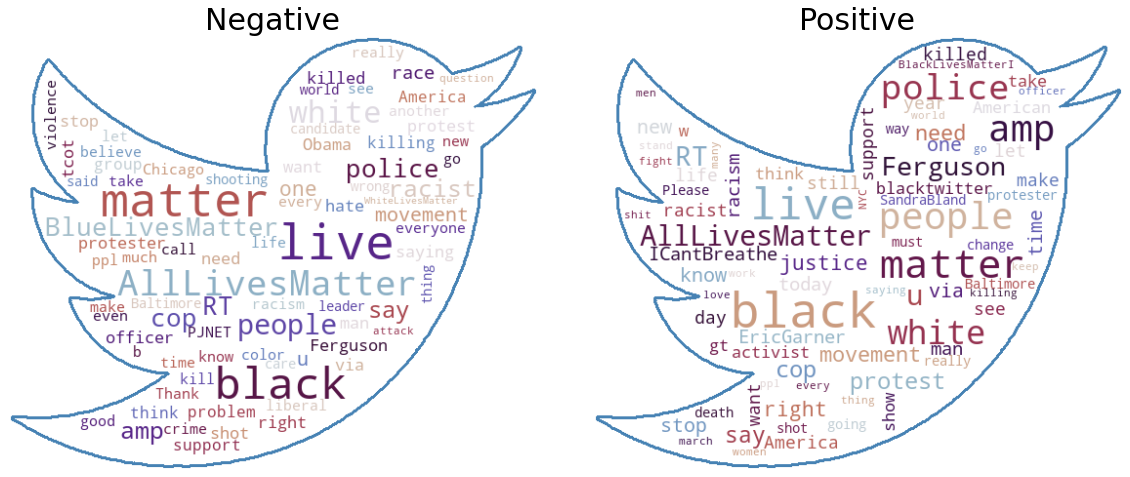

In [5]:
# create word bank for positive and negative tweets separately
text_pos = ''.join([''+j for j in train_df[train_df['BLM'] == 'positive']['text']])
text_neg = ''.join([''+j for j in train_df[train_df['BLM'] == 'negative']['text']])

# remove some of the more common words that provide little information (i.e. stop words)
# SW == list of swtop words + words that are common to both pos and neg tweets
SW = set(list(stop_words)+list(STOPWORDS)+['BlackLivesMatter'])


fig = plt.figure(figsize=(20,20))

# Word cloud for negative tweets
plt.subplot(1,2,1)
wordcloud = WordCloud(max_font_size=50,min_font_size = 8,max_words = 80, colormap='twilight',
               collocations=False,stopwords=SW,contour_width=3, contour_color='steelblue',
                      background_color='white',prefer_horizontal = 0.9,mask=twitterBird_mask).generate(text_neg)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Negative',{'fontsize':30})

# Word cloud for positive tweets
plt.subplot(1,2,2)
wordcloud = WordCloud(max_font_size=50,min_font_size = 8,max_words = 80, colormap='twilight',
               collocations=False,stopwords=SW,contour_width=3, contour_color='steelblue',
                      background_color='white',prefer_horizontal = 0.9,mask=twitterBird_mask).generate(text_pos)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Positive',{'fontsize':30})
plt.background_color = 'none'
plt.subplots_adjust(wspace = .1)


fig.savefig('wordCloud.jpg', dpi = 300,)

### Now preprocess the data and create a bag of words for more detailed analysis

In [6]:
# Preprocess the training dataset 
train_df.fillna("", inplace=True) 
train_df = preprocess_df(train_df)
train_df.reset_index(drop=True,inplace=True)
train_df.head()

# Preprocess the testing dataset
test_df.fillna("", inplace=True) 
test_df = preprocess_df(test_df)
test_df.reset_index(drop=True,inplace=True)
test_df.head()

# Uses a CountVectorizer to construct bag-of-words matrix
vectorizer = CountVectorizer() 
# train_vocab is an 2d array of the vocab from the training dataset 
train_vocab = vectorizer.fit_transform(train_df['text']).toarray()
# train_vocab_df is a dataframe where the element ij is the number of times word j occurred in Tweet i
train_vocab_df = pd.DataFrame(train_vocab, columns=vectorizer.get_feature_names())
train_vocab_df['BLM'] = train_df['BLM']


# Uses the vocab from the training dataset to vectorize the test dataset
# train_vocab is an 2d array of the vocab from the training dataset 
test_vocab = vectorizer.transform(test_df['text']).toarray()
# test_vocab_df is a dataframe where the element i,j is the number of times word j occurred in Tweet i
test_vocab_df = pd.DataFrame(test_vocab, columns=vectorizer.get_feature_names())
test_vocab_df['BLM'] = test_df['BLM']

train_vocab_df.head()

,0000001,02125,03,062817,07,10,100,1000,10000,100000,...,𝐎𝐫,𝐖𝐡𝐚𝐭,𝐚𝐛𝐨𝐮𝐭,𝐝𝐨,𝐟𝐮𝐥𝐥𝐛𝐥𝐚𝐜𝐤,𝐡𝐚𝐥𝐟𝐛𝐥𝐚𝐜𝐤,𝐥𝐢𝐯𝐞𝐬,𝐦𝐚𝐭𝐭𝐞𝐫,𝐨𝐧𝐥𝐲,BLM
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative


In [7]:
# Add word count and character count as a feature 
Xword = train_vocab_df.sum(axis=1)
charColumn = [len(j) for j in train_vocab_df.columns]
Xchar = (train_vocab_df*charColumn).sum(axis=1)
train_vocab_df['charCount'] = Xchar
train_vocab_df['wordCount'] = Xword

# Add word count and character count as a feature
Xword = test_vocab_df.sum(axis=1)
charColumn = [len(j) for j in test_vocab_df.columns]
Xchar = (test_vocab_df*charColumn).sum(axis=1)
test_vocab_df['charCount'] = Xchar
test_vocab_df['wordCount'] = Xword

In [8]:
# compute the balance of the training set (number of positive and negative labels)
numPosTot = len(train_df[train_df['BLM']=='positive'])
numNegTot = len(train_df[train_df['BLM']=='negative'])
numTotTot = numPosTot+numNegTot

perNegTot = numNegTot/numTotTot
perPosTot = numPosTot/numTotTot

print('percentage of tweets that are negative: %.2f' % (perNegTot*100))
print('percentage of tweets that are positive: %.2f' % (perPosTot*100))

percentage of tweets that are negative: 18.61
percentage of tweets that are positive: 81.39


In [9]:
# construct a dataframe based on word count features
wordCountTot = train_vocab_df.drop(['charCount','wordCount','BLM'],axis=1).sum(axis=0)
wordCountPos = train_vocab_df[train_vocab_df['BLM'] == 'positive'].drop(['charCount','wordCount','BLM'],axis=1).sum(axis=0)
wordCountNeg = train_vocab_df[train_vocab_df['BLM'] == 'negative'].drop(['charCount','wordCount','BLM'],axis=1).sum(axis=0)
train_df_wordFreq = pd.DataFrame(data=[wordCountTot, wordCountPos, wordCountNeg]).T
train_df_wordFreq.rename(columns={0: "wordCount", 1:"numPos", 2: "numNeg"},inplace=True)

# add percentage of negative and positive tweets
train_df_wordFreq['perNeg'] = train_df_wordFreq['numNeg']/train_df_wordFreq['wordCount'] 
train_df_wordFreq['perPos'] = train_df_wordFreq['numPos']/train_df_wordFreq['wordCount'] 

# sort dataframe by word count (descending)
train_df_wordFreq.sort_values(by='wordCount',ascending=False,inplace=True)
train_df_wordFreq.reset_index(inplace=True)
train_df_wordFreq.rename(columns={'index':'word'},inplace=True)


train_df_wordFreq.head()

,word,wordCount,numPos,numNeg,perNeg,perPos
0,blacklivesmatter,5976,5181,795,0.133032,0.866968
1,black,1112,810,302,0.271583,0.728417
2,life,1044,659,385,0.368774,0.631226
3,all,979,631,348,0.355465,0.644535
4,matter,904,547,357,0.394912,0.605088


### Plot histogram showing the percentage of positive tweets and negative tweets associated with a specific word

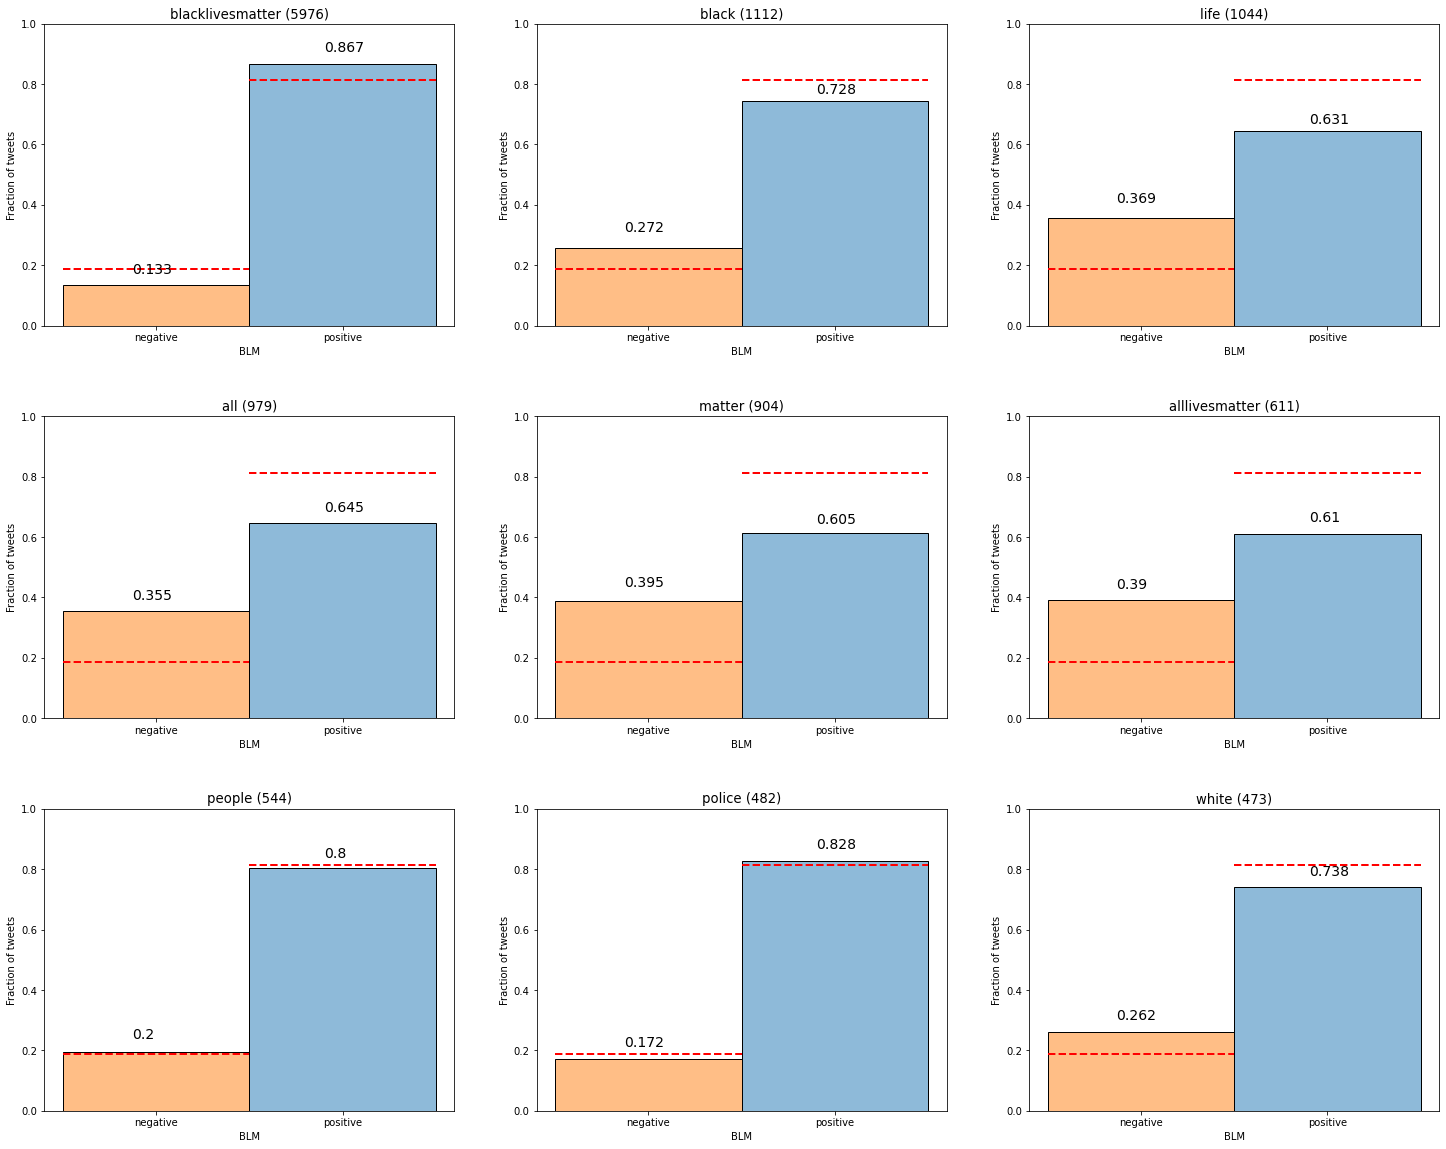

In [10]:
ns = 3
fig, axes = plt.subplots(ns,ns,figsize=(25,20))
plt.rcParams.update({'font.size': 11})
for j in range(ns):
    for k in range(ns):
        ht = train_df[train_vocab_df[train_df_wordFreq['word'][ns*j+k]] > 0]
        ht = ht.sort_values('BLM')
        sns.histplot(x='BLM',data=ht,stat='probability',ax=axes[j][k],hue='BLM',hue_order=['positive','negative'],legend=False)
        axes[j][k].set_title(train_df_wordFreq['word'][ns*j+k] + " (" + str(train_df_wordFreq['wordCount'][ns*j+k]) + ")")
        axes[j][k].hlines(y=.813, xmin=.5, xmax=1.5, colors='r', linestyles='--', lw=2)
        axes[j][k].hlines(y=.187, xmin=-.5, xmax=.5, colors='r', linestyles='--', lw=2)
        axes[j][k].set_ylabel("Fraction of tweets")
        
        perNegTemp = np.round(train_df_wordFreq['perNeg'][ns*j+k],3)
        perPosTemp = np.round(train_df_wordFreq['perPos'][ns*j+k],3)
        axes[j][k].text(0.9,perPosTemp+.04,str(perPosTemp),{'fontsize':14})
        axes[j][k].text(-0.13,perNegTemp+.04,str(perNegTemp),{'fontsize':14})
        axes[j][k].set_ylim([0,1]);
        
plt.subplots_adjust(hspace = .3)

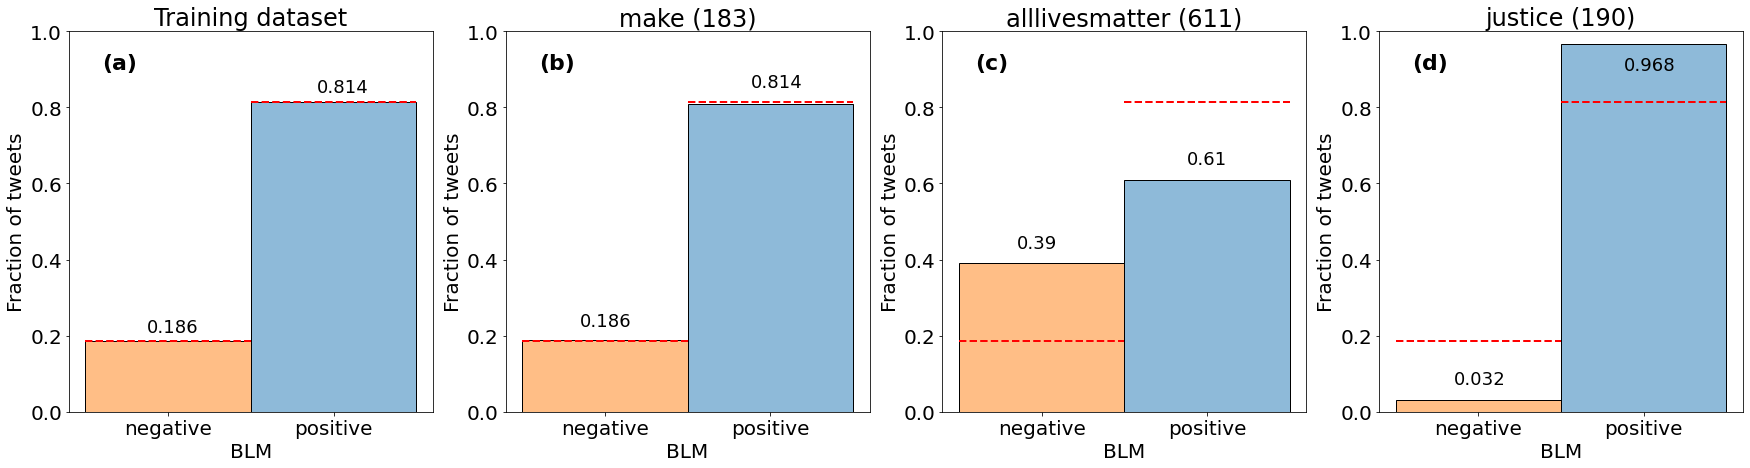

In [11]:
# create three bar plots showing how words can be associated as negative, positive, or neutral
jwords = []
jwords.append(np.nan)#,30,7,28]  
jwords.append(list(train_df_wordFreq['word']).index('make'))
jwords.append(list(train_df_wordFreq['word']).index('alllivesmatter'))
jwords.append(list(train_df_wordFreq['word']).index('justice'))

plt.rcParams.update({'font.size': 20})

fig, axes = plt.subplots(1,4,figsize=(30,7))

sns.histplot(x='BLM',data=train_df,stat='probability',ax=axes[0],hue='BLM',hue_order=['positive','negative'],legend = False)
axes[0].set_title("Training dataset")
axes[0].set_ylabel("Fraction of tweets")
axes[0].text(0.9,.84,'0.814',{'fontsize':18})
axes[0].text(-0.13,.21,'0.186',{'fontsize':18})
axes[0].hlines(y=.814, xmin=.5, xmax=1.5, colors='r', linestyles='--', lw=2)
axes[0].hlines(y=.186, xmin=-.5, xmax=.5, colors='r', linestyles='--', lw=2)
axes[0].set_ylim([0,1]);

for j in range(1,4):
    ht = train_df[train_vocab_df[train_df_wordFreq['word'][jwords[j]]] > 0]
    ht = ht.sort_values('BLM')
    sns.histplot(x='BLM',data=ht,stat='probability',ax=axes[j],hue='BLM',hue_order=['positive','negative'],legend=False)
    axes[j].set_title(train_df_wordFreq['word'][jwords[j]] + " (" + str(train_df_wordFreq['wordCount'][jwords[j]]) + ")")
    axes[j].hlines(y=.814, xmin=.5, xmax=1.5, colors='r', linestyles='--', lw=2)
    axes[j].hlines(y=.186, xmin=-.5, xmax=.5, colors='r', linestyles='--', lw=2)
    axes[j].set_ylabel("Fraction of tweets")

    perNegTemp = np.round(train_df_wordFreq['perNeg'][jwords[j]],3)
    perPosTemp = np.round(train_df_wordFreq['perPos'][jwords[j]],3)
    if(j == 3):
        axes[j].text(0.88,perPosTemp-.07,str(perPosTemp),{'fontsize':18})
    else:
        axes[j].text(0.88,perPosTemp+.04,str(perPosTemp),{'fontsize':18})
    axes[j].text(-0.15,perNegTemp+.04,str(perNegTemp),{'fontsize':18})
    axes[j].set_ylim([0,1]);


axes[0].text(-0.40,0.90,'(a)',{'fontweight':'bold','fontsize':22})
axes[1].text(-0.40,0.90,'(b)',{'fontweight':'bold','fontsize':22})
axes[2].text(-0.40,0.90,'(c)',{'fontweight':'bold','fontsize':22})
axes[3].text(-0.40,0.90,'(d)',{'fontweight':'bold','fontsize':22});

fig.savefig('histograms.jpg', dpi = 300,)

# Section IV: Hypothesis testing of word count to trim vocabulary

In [12]:
# run binomial test to determine if word is significant
numPosArray = train_df_wordFreq['numPos'].values
numTotArray = train_df_wordFreq['wordCount'].values
pvalue = np.zeros((len(numPosArray),))
for i in range(len(pvalue)):
    pvalue[i] = binom_test(x=numPosArray[i], n=numTotArray[i], p=perPosTot, alternative='two-sided')

train_df_wordFreq['pvalue'] = pvalue
train_df_wordFreq['ABTest'] = train_df_wordFreq['pvalue']<0.05

train_df_wordFreq.head()

,word,wordCount,numPos,numNeg,perNeg,perPos,pvalue,ABTest
0,blacklivesmatter,5976,5181,795,0.133032,0.866968,5.817181e-28,True
1,black,1112,810,302,0.271583,0.728417,3.141865e-12,True
2,life,1044,659,385,0.368774,0.631226,1.379113e-43,True
3,all,979,631,348,0.355465,0.644535,8.603104e-36,True
4,matter,904,547,357,0.394912,0.605088,3.069044e-48,True


# Section V: Form training and testing data

In [13]:
# first select chosen vocabulary from data
X_train = train_vocab_df[train_df_wordFreq[train_df_wordFreq['ABTest'] == True]['word']].copy()
X_test = test_vocab_df[train_df_wordFreq[train_df_wordFreq['ABTest'] == True]['word']].copy()

X_train[['BLM','wordCount','charCount']] = train_vocab_df[['BLM','wordCount','charCount']]
X_test[['BLM','wordCount','charCount']] = test_vocab_df[['BLM','wordCount','charCount']]

print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7238 entries, 0 to 7237
Columns: 401 entries, blacklivesmatter to charCount
dtypes: int64(400), object(1)
memory usage: 22.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1811 entries, 0 to 1810
Columns: 401 entries, blacklivesmatter to charCount
dtypes: int64(400), object(1)
memory usage: 5.5+ MB
None


In [14]:
# Remove all columns instnaces below a certain word-count
ncountlow = 10      # lower bound for word count
ncountupp = 50000    # upper bound for word count

rn = train_df_wordFreq[(train_df_wordFreq['ABTest'] == True) & ((train_df_wordFreq['wordCount'] >= ncountupp) | (train_df_wordFreq['wordCount'] <= ncountlow))]['word']
X_train.drop(labels=rn,inplace=True,axis=1)
X_test.drop(labels=rn,inplace=True,axis=1)


In [15]:
X_train = X_train[X_train['wordCount'] > 0]
X_test = X_test[X_test['wordCount'] > 0]

In [16]:
y_train = np.ravel(pd.get_dummies(data=X_train['BLM'],drop_first=True))
y_test = np.ravel(pd.get_dummies(data=X_test['BLM'],drop_first=True))

In [17]:
X_train.drop('BLM',axis=1,inplace=True)
X_test.drop('BLM',axis=1,inplace=True)

In [18]:
# finally, use MinMaxScaler to transform the data
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Section VI: Train machine learning models for classification: 
    - Logisitc regression
    - Multinomial Naive Bayes
    - Complement Naive Bayes
    - SVM (Linear kernel)
    - SVM (Radial basis functions kernel)
    - Random Forest
    - KNN 
    - LDA

Cross validation is used for hyperparameter selection.
Code adapted from sci-kit learn online documentation

## Logistic regression

C =    0.008, accuracy = 0.8139+/-0.0003, execution time =    0 sec
C =    0.016, accuracy = 0.8139+/-0.0003, execution time =    0 sec
C =    0.031, accuracy = 0.8147+/-0.0008, execution time =    0 sec
C =    0.062, accuracy = 0.8175+/-0.0005, execution time =    0 sec
C =    0.125, accuracy = 0.8236+/-0.0044, execution time =    0 sec
C =    0.250, accuracy = 0.8312+/-0.0070, execution time =    0 sec
C =    0.500, accuracy = 0.8363+/-0.0091, execution time =    0 sec
C =    1.000, accuracy = 0.8381+/-0.0121, execution time =    0 sec
C =    2.000, accuracy = 0.8403+/-0.0137, execution time =    0 sec
C =    4.000, accuracy = 0.8407+/-0.0137, execution time =    0 sec
C =    8.000, accuracy = 0.8421+/-0.0137, execution time =    0 sec
C =   16.000, accuracy = 0.8408+/-0.0150, execution time =    0 sec
C =   32.000, accuracy = 0.8404+/-0.0157, execution time =    1 sec
C =   64.000, accuracy = 0.8399+/-0.0156, execution time =    1 sec
C =  128.000, accuracy = 0.8404+/-0.0156, execut

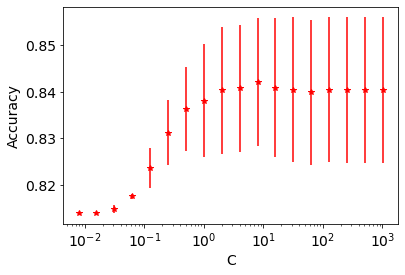

In [19]:
CR = [2**-7, 2**-6, 2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10]
avg = np.zeros((len(CR),))
std = np.zeros((len(CR),))
for j in range(len(CR)):
    t0 = time.time()    
    LogReg = LogisticRegression(C=CR[j],max_iter=1000)
    scores = cross_val_score(LogReg, X_train, y_train, cv=5)
    avg[j] = np.mean(scores)
    std[j] = np.std(scores)
    t1 = time.time()
    print('C = %8.3f, accuracy = %.4f+/-%.4f, execution time = %4.0f sec' % (CR[j],avg[j],std[j],(t1-t0)))
    
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
plt.errorbar(CR,avg,yerr=std,fmt='r*')
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
ax.set_xscale('log')

In [20]:
LogReg = LogisticRegression(C=4,max_iter=1000)
LogReg.fit(X_train,y_train)
predLogReg = LogReg.predict(X_test)
predLogRegP = LogReg.predict_proba(X_test)

## k-nearest neighbors

k =    1, accuracy = 0.7778+/-0.0216, execution time =    3 sec
k =    2, accuracy = 0.7420+/-0.0243, execution time =    4 sec
k =    4, accuracy = 0.7940+/-0.0268, execution time =    4 sec
k =    8, accuracy = 0.8132+/-0.0239, execution time =    5 sec
k =   16, accuracy = 0.8211+/-0.0174, execution time =    6 sec
k =   32, accuracy = 0.8203+/-0.0116, execution time =    6 sec
k =   64, accuracy = 0.8150+/-0.0113, execution time =    6 sec
k =  128, accuracy = 0.8139+/-0.0012, execution time =    7 sec
k =  256, accuracy = 0.8139+/-0.0003, execution time =    8 sec


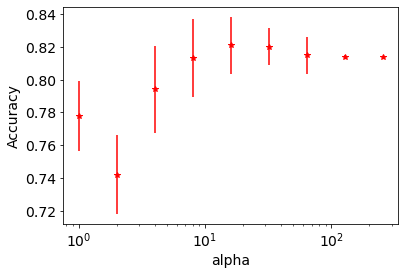

In [21]:
kR = [2**0, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8]
avg = np.zeros((len(kR),))
std = np.zeros((len(kR),))
for j in range(len(kR)):
    t0 = time.time()
    neigh = KNeighborsClassifier(n_neighbors=kR[j])
    scores = cross_val_score(neigh, X_train, y_train, cv=5)
    avg[j] = np.mean(scores)
    std[j] = np.std(scores)
    t1 = time.time()
    print('k = %4d, accuracy = %.4f+/-%.4f, execution time = %4.0f sec' % (kR[j],avg[j],std[j],(t1-t0)))
      
fig, ax = plt.subplots()
plt.errorbar(kR,avg,yerr=std,fmt='r*')
ax.set_xlabel('alpha')
ax.set_ylabel('Accuracy')
ax.set_xscale('Log')

In [22]:
neigh = KNeighborsClassifier(n_neighbors=16)
neigh.fit(X_train, y_train)
predKNN = neigh.predict(X_test)
predKNNP = neigh.predict_proba(X_test)

## Random forest

num. trees =      1, accuracy = 0.7563+/-0.0147, execution time =    0 sec
num. trees =      2, accuracy = 0.7235+/-0.0304, execution time =    0 sec
num. trees =      4, accuracy = 0.7657+/-0.0182, execution time =    0 sec
num. trees =      8, accuracy = 0.7916+/-0.0247, execution time =    1 sec
num. trees =     16, accuracy = 0.8037+/-0.0244, execution time =    1 sec
num. trees =     32, accuracy = 0.8113+/-0.0197, execution time =    2 sec
num. trees =     64, accuracy = 0.8135+/-0.0213, execution time =    5 sec
num. trees =    128, accuracy = 0.8132+/-0.0186, execution time =    9 sec
num. trees =    256, accuracy = 0.8150+/-0.0193, execution time =   17 sec
num. trees =    512, accuracy = 0.8162+/-0.0182, execution time =   33 sec


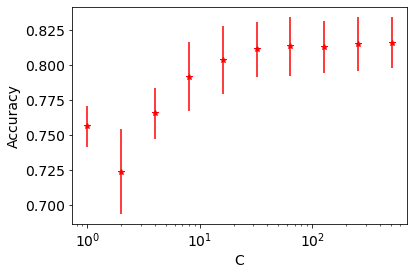

In [23]:
ne = [2**0, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9]
avg = np.zeros((len(ne),))
std = np.zeros((len(ne),))
for j in range(len(ne)):
    t0 = time.time()
    rf = RandomForestClassifier(n_estimators=ne[j])
    scores = cross_val_score(rf, X_train, y_train, cv=5)
    avg[j] = np.mean(scores)
    std[j] = np.std(scores)
    t1 = time.time()
    print('num. trees = %6.0f, accuracy = %.4f+/-%.4f, execution time = %4.0f sec' % (ne[j],avg[j],std[j],(t1-t0)))

fig, ax = plt.subplots()
plt.errorbar(ne,avg,yerr=std,fmt='r*')
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
ax.set_xscale('log')

In [24]:
# choose n_estimators = 128 based on above results
rf = RandomForestClassifier(n_estimators=128)
rf.fit(X_train,y_train)
predRF = rf.predict(X_test)
predRFP = rf.predict_proba(X_test)

## Linear discriminant analysis

In [25]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train, y_train)
predLDA = LDA.predict(X_test)
predLDAP = LDA.predict_proba(X_test)

## SVM (Linear)

C =   0.0078, accuracy = 0.8139+/-0.0003, execution time =    9 sec
C =   0.0156, accuracy = 0.8139+/-0.0003, execution time =   10 sec
C =   0.0312, accuracy = 0.8157+/-0.0006, execution time =   10 sec
C =   0.0625, accuracy = 0.8211+/-0.0027, execution time =   10 sec
C =   0.1250, accuracy = 0.8252+/-0.0069, execution time =    9 sec
C =   0.2500, accuracy = 0.8263+/-0.0085, execution time =   10 sec
C =   0.5000, accuracy = 0.8254+/-0.0094, execution time =   10 sec
C =   1.0000, accuracy = 0.8263+/-0.0108, execution time =   10 sec
C =   2.0000, accuracy = 0.8225+/-0.0113, execution time =   11 sec
C =   4.0000, accuracy = 0.8218+/-0.0112, execution time =   10 sec
C =   8.0000, accuracy = 0.8222+/-0.0105, execution time =   12 sec
C =  16.0000, accuracy = 0.8223+/-0.0102, execution time =   13 sec
C =  32.0000, accuracy = 0.8212+/-0.0100, execution time =   14 sec
C =  64.0000, accuracy = 0.8211+/-0.0104, execution time =   16 sec
C = 128.0000, accuracy = 0.8212+/-0.0103, execut

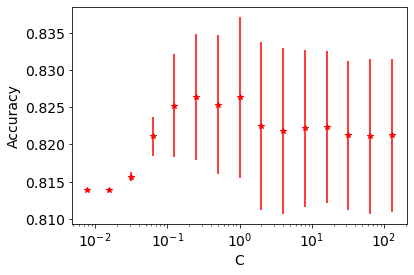

In [26]:
CR = [2**-7, 2**-6, 2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7]
avg = np.zeros((len(CR),))
std = np.zeros((len(CR),))
for j in range(len(CR)):
    t0 = time.time()
    svmlin = svm.SVC(kernel='linear',C=CR[j])
    scores = cross_val_score(svmlin, X_train, y_train, cv=5)
    avg[j] = np.mean(scores)
    std[j] = np.std(scores)
    t1 = time.time()
    print('C = %8.4f, accuracy = %.4f+/-%.4f, execution time = %4.0f sec' % (CR[j],avg[j],std[j],(t1-t0)))
      
fig, ax = plt.subplots()
plt.errorbar(CR,avg,yerr=std,fmt='r*')
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
ax.set_xscale('log')

In [27]:
svmlin = svm.SVC(kernel='linear',C=0.5,probability=True)
svmlin.fit(X_train, y_train)
predsvmlin = svmlin.predict(X_test)
predsvmlinP = svmlin.predict_proba(X_test)

## SVM (radial basis function)

C =  0.0078, accuracy = 0.8139+/-0.0003, execution time =   15 sec
C =  0.0156, accuracy = 0.8139+/-0.0003, execution time =   14 sec
C =  0.0312, accuracy = 0.8139+/-0.0003, execution time =   15 sec
C =  0.0625, accuracy = 0.8139+/-0.0003, execution time =   14 sec
C =  0.1250, accuracy = 0.8158+/-0.0016, execution time =   13 sec
C =  0.2500, accuracy = 0.8203+/-0.0033, execution time =   13 sec
C =  0.5000, accuracy = 0.8223+/-0.0058, execution time =   14 sec
C =  1.0000, accuracy = 0.8259+/-0.0084, execution time =   14 sec
C =  2.0000, accuracy = 0.8294+/-0.0112, execution time =   15 sec
C =  4.0000, accuracy = 0.8299+/-0.0117, execution time =   15 sec
C =  8.0000, accuracy = 0.8288+/-0.0133, execution time =   17 sec
C = 16.0000, accuracy = 0.8241+/-0.0139, execution time =   17 sec
C = 32.0000, accuracy = 0.8214+/-0.0145, execution time =   18 sec
C = 64.0000, accuracy = 0.8208+/-0.0160, execution time =   18 sec
C = 128.0000, accuracy = 0.8178+/-0.0161, execution time =   2

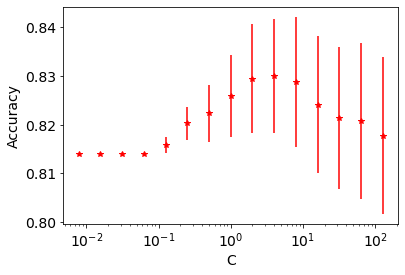

In [28]:
CR = [2**-7, 2**-6, 2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7]
avg = np.zeros((len(CR),))
std = np.zeros((len(CR),))
for j in range(len(CR)):
    t0 = time.time()
    svmrbf = svm.SVC(kernel='rbf',C=CR[j],gamma='scale')
    scores = cross_val_score(svmrbf, X_train, y_train, cv=5)
    avg[j] = np.mean(scores)
    std[j] = np.std(scores)
    t1 = time.time()
    print('C = %7.4f, accuracy = %.4f+/-%.4f, execution time = %4.0f sec' % (CR[j],avg[j],std[j],(t1-t0)))
    
    
fig, ax = plt.subplots()
plt.errorbar(CR,avg,yerr=std,fmt='r*')
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
ax.set_xscale('log')

In [29]:
svmrbf = svm.SVC(kernel='rbf',C=2,probability=True)
svmrbf.fit(X_train, y_train)
predsvmrbf = svmrbf.predict(X_test)
predsvmrbfP = svmrbf.predict_proba(X_test)

## Naive Bayes (Multinomial)

C =   0.0100, accuracy = 0.8265+/-0.0113, execution time =    0 sec
C =   0.1090, accuracy = 0.8263+/-0.0104, execution time =    0 sec
C =   0.2080, accuracy = 0.8265+/-0.0102, execution time =    0 sec
C =   0.3070, accuracy = 0.8265+/-0.0098, execution time =    0 sec
C =   0.4060, accuracy = 0.8274+/-0.0099, execution time =    0 sec
C =   0.5050, accuracy = 0.8269+/-0.0094, execution time =    0 sec
C =   0.6040, accuracy = 0.8270+/-0.0099, execution time =    0 sec
C =   0.7030, accuracy = 0.8273+/-0.0097, execution time =    0 sec
C =   0.8020, accuracy = 0.8272+/-0.0098, execution time =    0 sec
C =   0.9010, accuracy = 0.8272+/-0.0096, execution time =    0 sec
C =   1.0000, accuracy = 0.8267+/-0.0099, execution time =    0 sec


Text(0, 0.5, 'Accuracy')

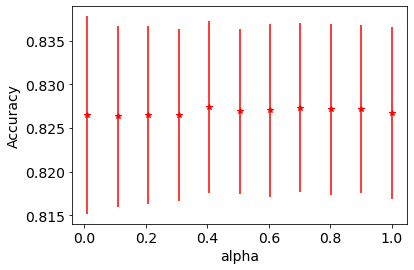

In [30]:
alphR = np.linspace(0.01,1,11)
avg = np.zeros((len(alphR),))
std = np.zeros((len(alphR),))
for j in range(len(alphR)):
    t0 = time.time()
    MNB = MultinomialNB(alpha=alphR[j])
    scores = cross_val_score(MNB, X_train, y_train, cv=5)
    avg[j] = np.mean(scores)
    std[j] = np.std(scores)
    t1 = time.time()
    print('C = %8.4f, accuracy = %.4f+/-%.4f, execution time = %4.0f sec' % (alphR[j],avg[j],std[j],(t1-t0)))
      
fig, ax = plt.subplots()
plt.errorbar(alphR,avg,yerr=std,fmt='r*')
ax.set_xlabel('alpha')
ax.set_ylabel('Accuracy')

In [31]:
MNB = MultinomialNB(alpha=0.5)
MNB.fit(X_train, y_train)
predMNB = MNB.predict(X_test)
predMNBP = MNB.predict_proba(X_test)

## Naive Bayes (Complement)

C =   0.0100, accuracy = 0.7349+/-0.0505, execution time =    0 sec
C =   0.1090, accuracy = 0.7351+/-0.0507, execution time =    0 sec
C =   0.2080, accuracy = 0.7364+/-0.0514, execution time =    0 sec
C =   0.3070, accuracy = 0.7369+/-0.0519, execution time =    0 sec
C =   0.4060, accuracy = 0.7362+/-0.0520, execution time =    0 sec
C =   0.5050, accuracy = 0.7379+/-0.0520, execution time =    0 sec
C =   0.6040, accuracy = 0.7373+/-0.0515, execution time =    0 sec
C =   0.7030, accuracy = 0.7376+/-0.0510, execution time =    0 sec
C =   0.8020, accuracy = 0.7379+/-0.0503, execution time =    0 sec
C =   0.9010, accuracy = 0.7389+/-0.0503, execution time =    0 sec
C =   1.0000, accuracy = 0.7386+/-0.0501, execution time =    0 sec


Text(0, 0.5, 'Accuracy')

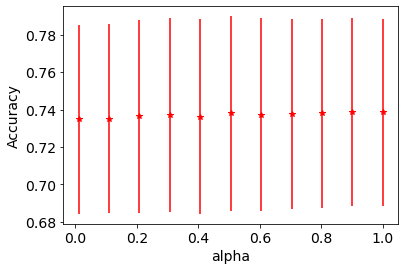

In [32]:
alphR = np.linspace(0.01,1,11)
avg = np.zeros((len(alphR),))
std = np.zeros((len(alphR),))
for j in range(len(alphR)):
    t0 = time.time()
    CNB = ComplementNB(alpha=alphR[j])
    scores = cross_val_score(CNB, X_train, y_train, cv=5)
    avg[j] = np.mean(scores)
    std[j] = np.std(scores)
    t1 = time.time()
    print('C = %8.4f, accuracy = %.4f+/-%.4f, execution time = %4.0f sec' % (alphR[j],avg[j],std[j],(t1-t0)))
      
fig, ax = plt.subplots()
plt.errorbar(alphR,avg,yerr=std,fmt='r*')
ax.set_xlabel('alpha')
ax.set_ylabel('Accuracy')


In [33]:
CNB = ComplementNB(alpha=0.5)
CNB.fit(X_train, y_train)
predCNB = CNB.predict(X_test)
predCNBP = CNB.predict_proba(X_test)

# Section VII: Evaluate the performance of the classifiers

In [34]:
def summaryReport(cm,name):
    print('Evaluated Metrics:')
    print('|   Classifier   | Accuracy | Precision | Recall | F1-score |   TN   |   FP   |   FN   |   TP   |')
    print('|----------------|----------|-----------|--------|----------|--------|--------|--------|--------|')
    for j in range(len(name)):
        TN = cm[0,0,j]
        FP = cm[0,1,j]
        FN = cm[1,0,j]
        TP = cm[1,1,j]

        f1_score = 2*TP/(2*TP+FP+FN)
        recall = TP/(TP+FN)
        accuracy =  (TP+TN)/(TN+FP+FN+TP)
        precision = TP/(TP+FP)

        padding = ' '*np.int(np.ceil((15-len(name[j]))/2))
        name[j] = name[j] + padding

        print('|%16s|  %6.2f  |  %6.2f   |  %5.2f |  %5.2f   |  %4.d  |  %4.d  |  %4.d  |  %4.d  |' % 
              (name[j],accuracy,precision,recall ,f1_score ,TN,FP,FN,TP) )
        print('|----------------|----------|-----------|--------|----------|--------|--------|--------|--------|')
    print('')
          

def confusionMatrix(cm,name):
    for j in range(len(name)):
        TN = cm[0,0,j]
        FP = cm[0,1,j]
        FN = cm[1,0,j]
        TP = cm[1,1,j]
        
        print('Confusion matrix:'+name[j])
        print('|             | Pred. Neg. | Pred. Pos. |')
        print('|-------------|------------|------------|')
        print('| Actual Neg. | TN = %4.d  | FP = %4.d  |' % (TN,FP) )
        print('|-------------|------------|------------|')
        print('| Actual Pos. | FN = %4.d  | TP = %4.d  |' % (FN,TP) )
        print('|-------------|------------|------------|\n')

In [35]:
cm = np.zeros([2,2,8])
cm[:,:,0] = confusion_matrix(y_test,predKNN)
cm[:,:,1] = confusion_matrix(y_test,predMNB)
cm[:,:,2] = confusion_matrix(y_test,predLogReg)
cm[:,:,3] = confusion_matrix(y_test,predsvmlin)
cm[:,:,4] = confusion_matrix(y_test,predsvmrbf)
cm[:,:,5] = confusion_matrix(y_test,predCNB)
cm[:,:,6] = confusion_matrix(y_test,predLDA)
cm[:,:,7] = confusion_matrix(y_test,predRF)
summaryReport(cm,['KNN','M. Naive Bayes', 'Log. Reg.', 'SVM (Lin)','SVM (rbf)','C. Naive Bayes','LDA','Random Forest'])


Evaluated Metrics:
|   Classifier   | Accuracy | Precision | Recall | F1-score |   TN   |   FP   |   FN   |   TP   |
|----------------|----------|-----------|--------|----------|--------|--------|--------|--------|
|       KNN      |    0.83  |    0.85   |   0.97 |   0.90   |    76  |   261  |    44  |  1430  |
|----------------|----------|-----------|--------|----------|--------|--------|--------|--------|
| M. Naive Bayes |    0.82  |    0.84   |   0.97 |   0.90   |    59  |   278  |    47  |  1427  |
|----------------|----------|-----------|--------|----------|--------|--------|--------|--------|
|    Log. Reg.   |    0.83  |    0.85   |   0.96 |   0.90   |    90  |   247  |    66  |  1408  |
|----------------|----------|-----------|--------|----------|--------|--------|--------|--------|
|    SVM (Lin)   |    0.82  |    0.83   |   0.98 |   0.90   |    45  |   292  |    26  |  1448  |
|----------------|----------|-----------|--------|----------|--------|--------|--------|--------|
|

In [36]:
confusionMatrix(cm,['KNN','M. Naive Bayes', 'Log. Reg.', 'SVM (Lin)','SVM (rbf)','C. Naive Bayes','LDA','Random Forest'])

Confusion matrix:KNN
|             | Pred. Neg. | Pred. Pos. |
|-------------|------------|------------|
| Actual Neg. | TN =   76  | FP =  261  |
|-------------|------------|------------|
| Actual Pos. | FN =   44  | TP = 1430  |
|-------------|------------|------------|

Confusion matrix:M. Naive Bayes
|             | Pred. Neg. | Pred. Pos. |
|-------------|------------|------------|
| Actual Neg. | TN =   59  | FP =  278  |
|-------------|------------|------------|
| Actual Pos. | FN =   47  | TP = 1427  |
|-------------|------------|------------|

Confusion matrix:Log. Reg.
|             | Pred. Neg. | Pred. Pos. |
|-------------|------------|------------|
| Actual Neg. | TN =   90  | FP =  247  |
|-------------|------------|------------|
| Actual Pos. | FN =   66  | TP = 1408  |
|-------------|------------|------------|

Confusion matrix:SVM (Lin)
|             | Pred. Neg. | Pred. Pos. |
|-------------|------------|------------|
| Actual Neg. | TN =   45  | FP =  292  |
|-------

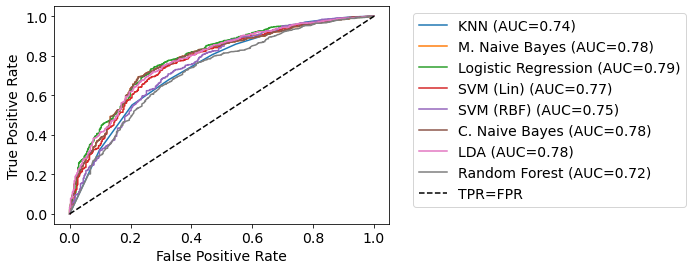

In [38]:
fig,ax = plt.subplots()

fpr, tpr, thresholds = roc_curve(y_test, predKNNP[:,1])
auc = roc_auc_score(y_test,predKNNP[:,1])
plt.plot(fpr,tpr,label='KNN (AUC='+np.str(np.round(auc,2))+')')

fpr, tpr, thresholds = roc_curve(y_test, predMNBP[:,1])
auc = roc_auc_score(y_test,predMNBP[:,1])
plt.plot(fpr,tpr,label='M. Naive Bayes (AUC='+np.str(np.round(auc,2))+')')

fpr, tpr, thresholds = roc_curve(y_test, predLogRegP[:,1])
auc = roc_auc_score(y_test,predLogRegP[:,1])
plt.plot(fpr,tpr,label='Logistic Regression (AUC='+np.str(np.round(auc,2))+')')

fpr, tpr, thresholds = roc_curve(y_test, predsvmlinP[:,1])
auc = roc_auc_score(y_test,predsvmlinP[:,1])
plt.plot(fpr,tpr,label='SVM (Lin) (AUC='+np.str(np.round(auc,2))+')')

fpr, tpr, thresholds = roc_curve(y_test, predsvmrbfP[:,1])
auc = roc_auc_score(y_test,predsvmrbfP[:,1])
plt.plot(fpr,tpr,label='SVM (RBF) (AUC='+np.str(np.round(auc,2))+')')

fpr, tpr, thresholds = roc_curve(y_test, predCNBP[:,1])
auc = roc_auc_score(y_test,predCNBP[:,1])
plt.plot(fpr,tpr,label='C. Naive Bayes (AUC='+np.str(np.round(auc,2))+')')

fpr, tpr, thresholds = roc_curve(y_test, predLDAP[:,1])
auc = roc_auc_score(y_test,predLDAP[:,1])
plt.plot(fpr,tpr,label='LDA (AUC='+np.str(np.round(auc,2))+')')

fpr, tpr, thresholds = roc_curve(y_test, predRFP[:,1])
auc = roc_auc_score(y_test,predRFP[:,1])
plt.plot(fpr,tpr,label='Random Forest (AUC='+np.str(np.round(auc,2))+')')

plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),'k--',label='TPR=FPR')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(1.05, 1.0),loc='upper left')

# Section VIII: Build an ensemble classifier

In [ ]:
# ensemble classifier via stacking
estimators = [('cnb',ComplementNB()),
              ('rf', RandomForestClassifier(n_estimators=30)),
             ('svmr',svm.SVC(kernel='rbf', C=200)),
             ('svml',svm.SVC(kernel='linear', C=2))]
stacked = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacked.fit(X_train,y_train)
predStacked = stacked.predict(X_test)

In [ ]:
# ensemble classifier via adaboost

In [ ]:
# ensemble classifier via gradient boosting classifier